In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

Let's have a look at one of the images:

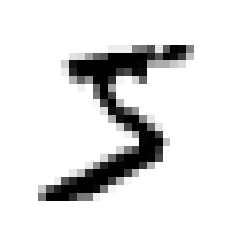

In [5]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

This is a five, let's look at the corresponding label then:

In [6]:
y[0]

'5'

Convert the labels from chars to ints

In [7]:
y = y.astype(np.uint8)

Split into train and test:

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a binary classifier

Let's simplify the problem into classifying 5's and non-5's. First, let's make the labels into boolean values and use linear Stochastic Gradient Descent classifier.

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

Now, let's test it using Cross-validation:

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Looks like a very high score, however - look what happens if we use a dumb classifier which always outputs False

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1),dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Waait so dumb classifier has 90% accuracy? Well, maybe because 90% of numbers in the dataset aren't 5? Way better tool would be confusion matrix

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

Ok, let's use confusion matrix then:

Each row represents and actual class, and columns show predicted class. So it goes like this:

$
\begin{bmatrix}
    True Positive & False Positive\\
    False Negative & True Negative
\end{bmatrix}
$

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

It's also worth to talk about precision of the classifier, so it's accuracy of the positive predictions.
$
precision = \frac{TP}{TP+FP}
$

On the other hand, recall is about ratio of positive instances detected by the classifier
$
recall = \frac{TP}{TP+FN}
$

In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

It is often convenient to combine precision and recall into a single metric called $F_{1}$, which is a harmonic mean of precision and recall. Regular mean treats all values equally, but harmonic mean gives much more weight to low values. So, classifier gets a high $F_{1}$ score if both recall and precision are high

$$F_{1}=\frac{2}{\frac{1}{precision}+\frac{1}{recall}}=2*\frac{precision*recall}{precision+recall}$$

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

It is worth mentioning that increasing precision reduces recall and vice versa. In some cases we want to have low recall, but high precision - classifying videos which are safe for kids, so we are very sure whether the given video is safe for kids.

In other cases we want to have low precision, but high recall. So eg computer vision system for finding a thief, might give false positives, but catch all the cases.

# Precision-recall curve

In [24]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions,recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    

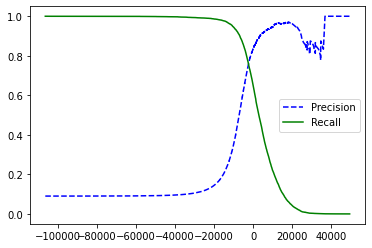

In [26]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.legend()
plt.show()

We can also plot precision directly vs recall, and then use it to calculate the threshold:

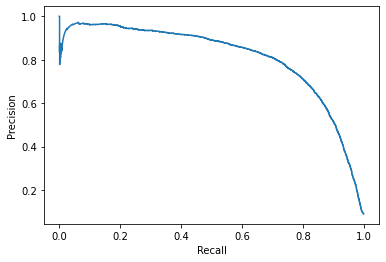

In [31]:
plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

In [32]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

3370.0194991439557


In [33]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [34]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [35]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# The ROC Curve
The receiver operating characteristic (ROC) curve is another common tool for binary classifiers. Similar to precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the true positive rate (recall) agains the false positive rate (1)

In [36]:
from sklearn.metrics import roc_curve

fpr,tpr,thresholds = roc_curve(y_train_5, y_scores)

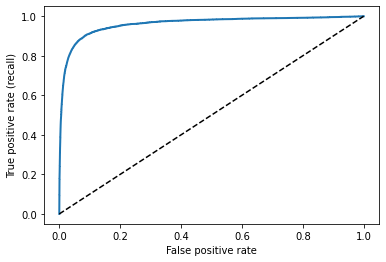

In [37]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr,tpr,linewidth=2, label=label)
    plt.plot([0,1],[0,1], 'k--') # Dashed diagonal
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate (recall)")
    
plot_roc_curve(fpr,tpr)
plt.show()

The dotted line shows the ROC curve of purely random classifier. A good classifier stays as far ffrom that line as possible (towards the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Sklearn has the function for it:

In [38]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

As ROC is similar to PR:

- Use PR when positive class is rare or when you care more about the false positives than the false negatives
- otherwise use ROC curve.

In this case, ROC curve looks good, but PR curve shows flaws

# Random Forest Classifier

In [39]:
from sklearn.ensemble import RandomForestClassifier


forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

`RandomForestClassifier` doesn't have `decision_function()` method. Instead it has a `predict_proba()`. It returns an array containing a row per instance and column per class, with probabilities that a given instance belongs to the given class

In [41]:
y_scores_forest = y_probas_forest[:, 1] #score = proba of the positive class
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

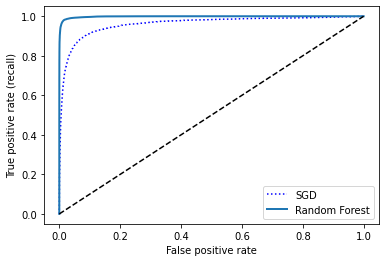

In [44]:
plt.plot(fpr,tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

Let's calculate the ROC AUC score then:

In [45]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# Multiclass classification

SGD, Random Forest and Naive bayes can distinguish between more than two classes. Others (logistic regression or SVMs) are strictly binary.
There are two ways of solving it:
- make 10 binary classifiers (OvR - one vs rest)
- make classifier for every pair of digits - 45 possible pairs in the case of MNIST - and see which class wins most of thee duels

Some classifiers scale poorly with the size of dataset (SVMs) so it is easy to train multiple classifiers on small dataset, however for most of classifiers OvR is preferred

In [47]:
#Sklearn detects when you try to usee binary classification algorithm, for multiclass classification
#So it automatically runs OvO or OvR depending on the algorithm

#Lets try it on SVM

from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [48]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [49]:
np.argmax(some_digit_scores)

5

In [50]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [51]:
svm_clf.classes_[5]

5

We can always force Sklearn to use OvO or OvR.

Let's to this for OvR based on SVM Classifier class

In [52]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [53]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [54]:
len(ovr_clf.estimators_)

10

In [56]:
ovr_clf.decision_function([some_digit])

array([[-2.20788779, -2.52734154, -1.42209483, -0.89545795, -3.66438164,
         1.09884347, -3.13930844, -2.05006487, -2.51601851, -3.39312853]])

Example with SGD classifier is even easier:

In [57]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [58]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [59]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [60]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

# Error analysis

Let's make confusion matrix for the stochastic descent classifier:

In [61]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

In [62]:
conf_mx = confusion_matrix(y_train, y_train_pred)

In [63]:
conf_mx

array([[5635,    0,   61,   10,   16,   50,   46,    7,   66,   32],
       [   3, 6393,   95,   21,   16,   47,   15,   27,  109,   16],
       [  72,   56, 5174,   89,   69,   39,  163,   66,  212,   18],
       [  58,   32,  217, 4941,   23,  441,   32,   56,  216,  115],
       [  11,   26,   46,    6, 5298,   26,   73,   32,   87,  237],
       [  68,   23,   58,  150,   83, 4606,  174,   26,  152,   81],
       [  40,   13,   56,    6,   22,  113, 5625,    5,   36,    2],
       [  23,   24,  103,   36,  124,   40,   10, 5228,   75,  602],
       [  40,  101,  158,  122,   49,  457,   77,   35, 4666,  146],
       [  33,   18,   66,   83,  515,  127,    4,  485,  166, 4452]])

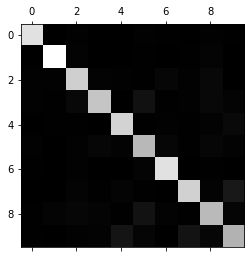

In [64]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

Divide the cells by total number of images in the corresponding class:

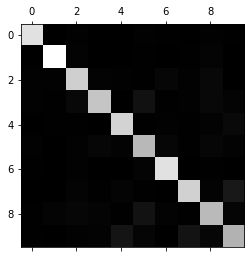

In [66]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
plt.matshow(conf_mx, cmap=plt.cm.gray)

Fill the diagonals with zeros to keep only errors, and plot the results:

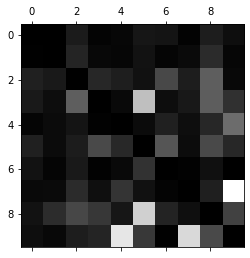

In [67]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

# Multilabel Classification
So, label can have more than one class, eg [1,0,1] can be a valid label

In [69]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel=np.c_[y_train_large, y_train_odd]

In [70]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [71]:
knn_clf.predict([some_digit])

array([[False,  True]])

Well, so it works nicely. 5 is not large, but it is odd